# Pytorch Deep Neural Networks

As in any deep learning framework, convolutional networks is the best intermediate level topic we can try out to implement. 

Before that, we need to download a dataset. Here we are using a dataset provided by `torchvision.datasets` module to download the CIFAR10 dataset.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plot

In [2]:
from torchvision import datasets
data_path = "datasets/"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
type(cifar10).__mro__ # this means `method resolution order`

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [4]:
img, label = cifar10[145]
cifar10.classes[label]

'deer'

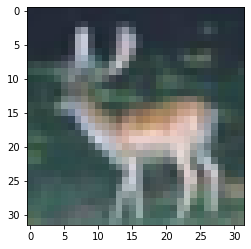

In [5]:
plot.imshow(img)
plot.show()

But above data need to be converted to pytorch tensors before we can use them in calculations. To do that we are provided with `torchvision.transform` module. This module helps us to apply transformations after the data set is loaded, before it is used.

In [6]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [7]:
to_tensor_transformer = transforms.ToTensor()
img_tensor = to_tensor_transformer(img)
img_tensor.shape

torch.Size([3, 32, 32])

So we can use above transormers as an input parameter to dataset like below.

In [8]:
cifar10_tensors = datasets.CIFAR10( data_path, 
                                    train=True, 
                                    download=False, 
                                    transform=transforms.ToTensor())

This transform image data to tensors and also normalize the values between 0, 1 range.

In [9]:
img_t, lbl = cifar10_tensors[99]
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

But since toTensor function change the image axis to make it more usable in Neural network context, we need to revert those changes back if we are required to rebuild the image. Example is like below.

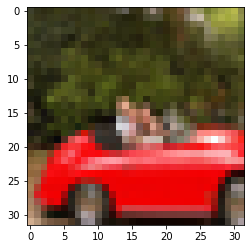

In [10]:
plot.imshow(img_t.permute(1, 2, 0))
plot.show()

Also we can use a `transform.Compose` to combine transformations as pipelines. Below is an example of such usage.

In [11]:
imgs = torch.stack([i for i, _ in cifar10_tensors], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [12]:
mean = imgs.view(3, -1).mean(dim=1) # Here we take a view with all image colors in 1 dimension.
std = imgs.view(3, -1).std(dim=1)

In [13]:
cifar10_tensors_t = datasets.CIFAR10( data_path, 
                                    train=True, 
                                    download=False, 
                                    transform=
                                        transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)
                                        ]))

In [17]:
cifar10_tensors_val_t = datasets.CIFAR10( data_path, 
                                    train=False, 
                                    download=False, 
                                    transform=
                                        transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)
                                        ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


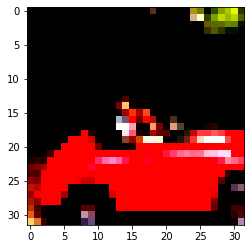

In [14]:
img_t, _ = cifar10_tensors_t[99]
plot.imshow(img_t.permute(1, 2, 0))
plot.show()

Now lets consider a task where we need to identify birds among planes. To train a neural network to support uch scenario we need to first create a dataset with birds and planes.

In [32]:
cifar_birdplane = [(img, min(label, 1))
                        for img, label in cifar10_tensors_t
                                if label in [0, 2]]

cifar_birdplane_val = [(img, min(label, 1))
                        for img, label in cifar10_tensors_val_t
                            if label in [0, 2]]

Since now we have prepared dataset, we can look in to the model building part.

In [35]:
import torch.nn as nn
import torch

n_out = 2 # Output neurons (But we can use only one since we have single classification).

train_loader = torch.utils.data.DataLoader(cifar_birdplane, batch_size=64, shuffle=True)

model = nn.Sequential(
                        nn.Linear(3072, 1024),
                        nn.Tanh(),
                        nn.Linear(1024, 512),
                        nn.Tanh(),
                        nn.Linear(512, 128),
                        nn.Tanh(),
                        nn.Linear(128, 2),
                    )
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        
        batch_size = imgs.shape[0]
        out = model(imgs.view(batch_size, -1)) # change input to tensor with single dimension
        loss = loss_fn(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%10==0):    
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.414086
Epoch: 10, Loss: 0.535918
Epoch: 20, Loss: 0.142412
Epoch: 30, Loss: 0.193025
Epoch: 40, Loss: 0.050684
Epoch: 50, Loss: 0.012793
Epoch: 60, Loss: 0.024600
Epoch: 70, Loss: 0.006390
Epoch: 80, Loss: 0.003055
Epoch: 90, Loss: 0.002798


In [38]:
train_loader = torch.utils.data.DataLoader(cifar_birdplane, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))

        _, predicted = torch.max(outputs, dim=1)
        
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy for training: %f", correct / total)

val_loader = torch.utils.data.DataLoader(cifar_birdplane_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))

        _, predicted = torch.max(outputs, dim=1)
        
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy for validation: %f", correct / total)

Accuracy for training: %f 1.0
Accuracy for validation: %f 0.8125


So what has happened here is that our model has overfitted to the training dataset. There are several methods to fix that, but now the point is we have built a deep neural network using pytorch!